<a href="https://colab.research.google.com/github/beaten-by-the-market/dart_disclosure/blob/main/kospi_dart_bonusissue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 코랩 환경에서 데이터 수집, 시각화를 하기 위해 필요한 라이브러리를 설치

In [2]:
# 필요한 라이브러리 설치
import pandas as pd
import requests
from io import BytesIO, StringIO
from time import sleep
from tqdm import tqdm
from bs4 import BeautifulSoup
import json
import re
import numpy as np
from datetime import datetime

# 시각화 관련
!pip install adjustText
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124574 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

#### 금감원 공시를 통해 **무상증자결정** 통계 불러오기
###### 검색기준 설정하기
검색 기준은 "유가", "2015~2024"년으로 하였습니다. 참고로 **OpenDart는 2015년부터 데이터를 제공**합니다.<br>

데이터를 불러오는 방식은 requests.post 입니다. Post방식을 위해서는 params를 설정해야 하는데, 이 안에 검색 기준이 들어가게 됩니다.<br>
취득이 경우 보고서 코드가 11332였지만, 이번에는 처분이므로 보고서 코드를 11333으로 수정합니다.

In [30]:
# 데이터 검색기준 설정하기
start_y = "2015"
end_y = "2024"
corp_type = "P" #유가는 "P", 코스닥은 "A", 유가및코스닥은 ["P", "A"] 입력
reportCode = "11307" #유상증자 11306, 무상증자 11307, 유무상증자 11308, 감자 11309, 상각형조건부자본증권 발행 11329

# 기본 params 템플릿
params = {
    "pageIndex": "1",
    "pageSize": "10",
    "pageUnit": "10",
    "recordCountPerPage": "1000",
    "sortStdr": "crp",
    "sortOrdr": "asc",
    "sumSortStdr": "",
    "sumSortOrdr": "asc",
    "textCrpCik": "",
    "bgnDe": f"{start_y}-01-01",
    "endDe": f"{end_y}-12-31",
    "textCrpNm": "",
    "startDate": f"{start_y}-01-01",
    "endDate": f"{end_y}-12-31",
    "reportCode": f"{reportCode}",
    "corpType" : f"{corp_type}"
}

# 결과 출력
params

{'pageIndex': '1',
 'pageSize': '10',
 'pageUnit': '10',
 'recordCountPerPage': '1000',
 'sortStdr': 'crp',
 'sortOrdr': 'asc',
 'sumSortStdr': '',
 'sumSortOrdr': 'asc',
 'textCrpCik': '',
 'bgnDe': '2015-01-01',
 'endDe': '2024-12-31',
 'textCrpNm': '',
 'startDate': '2015-01-01',
 'endDate': '2024-12-31',
 'reportCode': '11307',
 'corpType': 'P'}

###### 총 몇건, 몇페이지인지 확인하기
지금같이 10년치 데이터를 확인하려면 데이터의 행이 많을 것입니다.<br>
그런데 OpenDart 웹은 기본적으로 한 페이지에 표출시켜줄 수 있는 데이터의 양이 정해져 있습니다. 따라서 10년치를 검색하면 여러 페이지에 걸쳐서 데이터가 나뉘어 표출됩니다.<br>
여러 페이지에 걸쳐 loop을 돌려야 할텐데, 몇 페이지가 있는지 어떻게 확인할까요?<br>
첫번째 페이지를 크롤링 했을 때, 그 결과물에는 전체 페이지가 얼마나 되는지 정보가 포함되어 있습니다. 그리고 이 정보를 통해 총 페이지가 2이상인 것으로 확인되는 경우, 그 페이지수만큼 추가로 크롤링을 수행해야 합니다.<br>
<br>
우선 첫번째 페이지의 크롤링을 수행해 봅니다.<br>
취득을 수행했을 때 코드에서 업데이트한 부분은 다음과 같습니다. 취득건수는 1,000건이 안되어서 정규표현식 때 콤마를 인식하는 내용을 포함하지 않았었습니다. 그러나 처분의 경우 1,000건을 넘어서 이 부분을 포함시켰습니다.

In [31]:
# 첫번째 페이지를 기준으로 크롤링
url = 'https://opendart.fss.or.kr/disclosureinfo/mainMatter/list.do'
req = requests.post(url, params = params)
content = req.content.decode('utf-8')

# beautifulsoup 객체로 전환
soup = BeautifulSoup(content, 'html.parser')

# 끝에서 두번째 div 태그에 페이지 정보가 있음
output_string = soup.find_all('div')[-2].text

import re

# 정규 표현식을 사용하여 숫자 추출
# 백만단위 건수는 아닐거라는 가정임. 즉, 콤마가 많아도 하나만 있다는 가정임
match = re.match(r"\[(\d+)/(\d+)\] \[총 ((\d+)|(\d+)?,?(\d+))건\]", output_string)

if match:
    total_page = int(match.group(2))
    total_counts = match.group(3)
    print(f"total_page: {total_page}")
    print(f"total_counts: {total_counts}")
else:
    print("출력물 형식이 올바르지 않습니다.")

total_page: 2
total_counts: 142


총 142건이 있고, 총 2페이지에 걸쳐있습니다. 코스피 시장에선 많지 않네요. 참고로 같은 기간 코스닥에서는 499건 있었습니다.<br>
###### 데이터 수집하기
그럼 7번의 loop으로 HTML에 포함된 데이터프레임을 추출하고, 합치는 과정(pd.concat)을 진행하도록 하겠습니다.<br>
한편, 페이지 수를 확인하기 위해 이미 requests.post 한번 날려서 이미 'content'라는 변수를 받아놓았으므로, 첫번째 페이지의 데이터는 그것을 사용하고, 2페이지부터는 새로 requsts.post를 날리도록 하겠습니다.

In [32]:
# 데이터를 수집할 빈 데이터프레임(마스터 데이터프레임) 생성
df_dart_bi = pd.DataFrame()

# 이미 받아놓은 값(content)에서 첫번째 페이지의 데이터프레임 파싱
html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
df_loop = pd.read_html(html_string)[0]

# 마스터 데이터프레임에 합치기
df_dart_bi = pd.concat([df_dart_bi, df_loop])

for i in range(2, total_page + 1):
  page_index = str(i)
  # params 기준에서 페이지 인덱스만 수정하기
  params["pageIndex"] = page_index

  req = requests.post(url, params = params)
  content = req.content.decode('utf-8')
  html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
  df_loop = pd.read_html(html_string)[0]

  # IP차단을 위해 쉬어가기
  sleep(1)

  # 마스터 데이터프레임에 합치기
  df_dart_bi = pd.concat([df_dart_bi, df_loop])

###### 수집된 데이터프레임 형태 확인
데이터프레임이 어떤 형태인지 한번 확인해 보겠습니다.

In [33]:
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_dart_bi.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)
df_dart_bi.head()

<table border="1" class="dataframe dataframe">
  <thead>
    <tr>
      <th>회사명</th>
      <th>접수일</th>
      <th colspan="2" halign="left">신주의 종류와 수</th>
      <th>1주당 액면가액 (원)</th>
      <th colspan="2" halign="left">증자전 발행주식총수</th>
      <th>신주배정기준일</th>
      <th colspan="2" halign="left">1주당 신주배정 주식수</th>
      <th>신주의 배당기산일</th>
      <th>신주권교부예정일</th>
      <th>신주의 상장 예정일</th>
      <th>이사회결의일(결정일)</th>
      <th colspan="2" halign="left">사외이사 참석여부</th>
      <th>감사 (감사위원) 참석 여부</th>
      <th>비고</th>
    </tr>
    <tr>
      <th>회사명</th>
      <th>접수일</th>
      <th>보통주식 (주)</th>
      <th>기타주식 (주)</th>
      <th>1주당 액면가액 (원)</th>
      <th>보통주식 (주)</th>
      <th>기타주식 (주)</th>
      <th>신주배정기준일</th>
      <th>보통주식 (주)</th>
      <th>기타주식 (주)</th>
      <th>신주의 배당기산일</th>
      <th>신주권교부예정일</th>
      <th>신주의 상장 예정일</th>
      <th>이사회결의일(결정일)</th>
      <th>참석 (명)</th>
      <th>불참 (명)</th>
      <th>감사 (감사위원) 참석 여부</th>
      <th>비고</th>
    </tr>
  </thead>
  <tbody>
    <tr>

회사명         접수일 신주의 종류와 수          1주당 액면가액 (원) 증자전 발행주식총수           \
         회사명         접수일  보통주식 (주) 기타주식 (주) 1주당 액면가액 (원)   보통주식 (주) 기타주식 (주)   
0       유BGF  2016-11-07  24773661        -         1000   24773964        -   
1     유DL이앤씨  2022-03-24  19334885  2111951         5000   19358738  2113885   
2      유DS단석  2024-11-11  11722808        -          500    5861404        -   
3     유HDC랩스  2017-10-30   8230000        -          500    8230000        -   
4  유HD현대건설기계  2018-11-02   9824498        -         5000    9876295        -   

         신주배정기준일 1주당 신주배정 주식수               신주의 배당기산일       신주권교부예정일  \
         신주배정기준일     보통주식 (주) 기타주식 (주)      신주의 배당기산일       신주권교부예정일   
0  2016년 11월 24일          1.0        -  2016년 01월 01일  2016년 12월 13일   
1  2022년 04월 11일          1.0        1  2022년 01월 01일              -   
2  2024년 11월 26일          2.0        -  2024년 01월 01일              -   
3  2017년 11월 15일          1.0        -  2017년 01월 01일  2017년 12월 01일   
4  2018년 11월 20일          1.0        -  2018년 01월 01일  2018년 12월 17일   

      신주의 상장 예정일    이사회결의일(결정일) 사외이사 참석여부        감사 (감사위원) 참석 여부 비고  
      신주의 상장 예정일    이사회결의일(결정일)    참석 (명) 불참 (명) 감사 (감사위원) 참석 여부 비고  
0  2016년 12월 14일  2016년 11월 07일         1      -              참석  -  
1  2022년 04월 28일  2022년 03월 24일         4      -              참석  -  
2  2024년 12월 24일  2024년 11월 11일         3      -              참석  -  
3  2017년 12월 04일  2017년 10월 30일         1      1              불참  -  
4  2018년 12월 18일  2018년 11월 02일         2      1              참석  -

확인해보니 칼럼이 3층으로 되어 있습니다. 이런 경우 분석을 하기 번거로워지는 점이 있으니, 칼럼을 1층으로 포개 주도록 하겠습니다.
3층을 1층으로 포갤때 칼럼명이 어떻게 되는지를 먼저 확인하고, 중복된 내용은 없애서는 방식으로 칼럼명을 수정하도록 하겠습니다.

In [34]:
# 3층을 1층으로 포개었을 때 어떤 칼럼명들이 생성되는지 확인
print(['_'.join(map(str, filter(None, col))) for col in df_dart_bi.columns])

['회사명_회사명', '접수일_접수일', '신주의 종류와 수_보통주식 (주)', '신주의 종류와 수_기타주식 (주)', '1주당 액면가액 (원)_1주당 액면가액 (원)', '증자전 발행주식총수_보통주식 (주)', '증자전 발행주식총수_기타주식 (주)', '신주배정기준일_신주배정기준일', '1주당 신주배정 주식수_보통주식 (주)', '1주당 신주배정 주식수_기타주식 (주)', '신주의 배당기산일_신주의 배당기산일', '신주권교부예정일_신주권교부예정일', '신주의 상장 예정일_신주의 상장 예정일', '이사회결의일(결정일)_이사회결의일(결정일)', '사외이사 참석여부_참석 (명)', '사외이사 참석여부_불참 (명)', '감사 (감사위원) 참석 여부_감사 (감사위원) 참석 여부', '비고_비고']


매매방식을 기재하는 방식에서 취득공시와 다른 점이 있습니다.
* 자사주취득공시 : 처분방식을 ***하나의 칸에 free text로 기재***합니다.
* 자사주처분공시 : 처분방식을 ***시장, 시간외대량, 장외, 기타로 구분***을 하였고, 각각의 방식으로 처분할 수량을 기재하도록 하였습니다.

<br>
취득공시보다 처분공시에서 데이터 활용성이 높아졌습니다!

###### 데이터프레임 전처리

In [35]:
# 확인된 값을 바탕으로 칼럼명을 지정
df_dart_bi.columns = ['회사명', '접수일',
                      '신주의 종류와 수_보통주식 (주)',
                      '신주의 종류와 수_기타주식 (주)',
                      '1주당 액면가액 (원)',
                      '증자전 발행주식총수_보통주식 (주)', '증자전 발행주식총수_기타주식 (주)',
                      '신주배정기준일',
                      '1주당 신주배정 주식수_보통주식 (주)', '1주당 신주배정 주식수_기타주식 (주)',
                      '신주의 배당기산일', '신주권교부예정일',
                      '신주의 상장 예정일',
                      '이사회결의일(결정일)',
                      '사외이사 참석여부_참석 (명)', '사외이사 참석여부_불참 (명)',
                      '감사 (감사위원) 참석 여부_감사 (감사위원) 참석 여부', '비고']

데이터프레임에 몇가지의 조치를 더 취합니다.<br>
**1) 분석에 필요한 칼럼만 남깁니다.**<br>
물론 우선주에 대한 자기주식 취득도 있지만, 우선주가 상장되지 않은 경우가 더 많기 때문에, 보통주에 관한 것으로 한정합니다.<br><br>
**2) 단위를 조정합니다.**<br>
칼럼이 현재는 일괄로 str타입으로 되어있습니다. 따라서 분석을 위해 날짜, 숫자 형태 등으로 변경합니다.<br><br>
**2-1) 날짜의 표준화를 수행합니다.**<br>
자사주 분석때는 '접수일'을 기준으로 분석을 진행했습니다. 자사주 취득처분의 경우 시점이 확정되지 않고 기간을 두어 실행하기 때문입니다.<br>
그러나 무상증자의 경우, 기준날짜가 명확합니다. 배정기준일, 이사회결정일, 상장일을 기준날짜들로 볼 수 있는데, 기간이 아니라 특정 날짜 하루입니다.<br>
한편 최초로 시장에 무상증자 결정이 알려지는 시점은 이사회 결정일이므로, 본 분석에서는 이사회 결정일을 기준으로 하였습니다.<br>
그런데! 여기서 금감원 Dart 편집기의 특성을 고려해야 합니다. 회사는 금감원에서 제공한 공시문서작성 프로그램(Dart 편집기)를 사용하여 작성합니다. 그리고 Dart 편집기에서는 이사회결의일을 'YYYY년 MM월 DD일' 또는 'YYYY.MM.DD' 의 형태중에 회사가 자유롭게 선택해서 표출할 수 있도록 선택권을 주었습니다. 정보 이용자 측면에서는 이 두가지 케이스를 표준화 해주어야 합니다.<br><br>
**3) 회사명을 조정합니다.**<br>
OpenDart API가 아닌 웹페이지에서 크롤링해오다보니, 회사명에 다음과 같은 수식어들이 붙어있습니다. 이러한 수식어들을 제거하는 절차를 수행합니다.<br>
  * 시장구분자(유, 코, 넥, 기)가 회사명의 앞부분에 있습니다.
  * IR홈페이지가 있는 경우, 회사명 뒷부분에 'IR'이 붙어있습니다.

In [36]:
# 필요한 칼럼만 선택하고 이름을 변경하여 새로운 데이터프레임 생성
df_dart_bi = df_dart_bi[['회사명', '접수일',
                           '신주의 종류와 수_보통주식 (주)',
                           '증자전 발행주식총수_보통주식 (주)',
                           '1주당 신주배정 주식수_보통주식 (주)',
                           '신주배정기준일',
                           '신주의 상장 예정일',
                           '이사회결의일(결정일)']].copy()

df_dart_bi.columns = ['회사명', '접수일',
                      '신주의수','기존발행주식수','1주당신주',
                      '배정기준일','상장예정일', '이사회결의일']

In [37]:
#다트 편집기를 보면 날짜를 입력하는 형태는 두가지가 있다
#(1) 2022.08.03
#(2) 2022년 08월 03일
#따라서 두번째 형태일 경우 첫번째 형태로 전환하는 함수를 생성한다
def chg_date_format(date_input) :
    if '년' in date_input:
        new_year = date_input[0:4]
        new_month = date_input[6:8]
        new_day = date_input[10:12]
        new_date = new_year + new_month + new_day
    else :
        new_date = date_input
    return new_date

#생성한 함수를 통해서 포맷을 바꿔준다
df_dart_bi['이사회결의일'] = df_dart_bi.이사회결의일.apply(lambda x : chg_date_format(x))
df_dart_bi['배정기준일'] = df_dart_bi.배정기준일.apply(lambda x : chg_date_format(x))
df_dart_bi['상장예정일'] = df_dart_bi.상장예정일.apply(lambda x : chg_date_format(x))

# 접수일을 datetime으로 변환 및 연도 추출
df_dart_bi['이사회결의일'] = pd.to_datetime(df_dart_bi['이사회결의일'], errors='coerce')
df_dart_bi['연도'] = df_dart_bi['이사회결의일'].dt.year
df_dart_bi['배정기준일'] = pd.to_datetime(df_dart_bi['배정기준일'], errors='coerce')
df_dart_bi['상장예정일'] = pd.to_datetime(df_dart_bi['상장예정일'], errors='coerce')

# 데이터 타입 변경
df_dart_bi['연도'] = pd.to_numeric(df_dart_bi['연도'], errors='coerce').astype('Int64')

df_dart_bi['신주의수'] = pd.to_numeric(
    df_dart_bi['신주의수'], errors='coerce').fillna(0)

df_dart_bi['기존발행주식수'] = pd.to_numeric(
    df_dart_bi['기존발행주식수'], errors='coerce').fillna(0)

df_dart_bi['1주당신주'] = pd.to_numeric(
    df_dart_bi['1주당신주'], errors='coerce').fillna(0)

# 맨 앞의 '유' 또는 '코' 제거, 맨 끝의 'IR' 제거
df_dart_bi['회사명'] = df_dart_bi['회사명'].str.replace(r'^(유|코)', '', regex=True).str.replace(r'  IR$', '', regex=True).str.replace(r'IR$', '', regex=True)



###### 전처리한 데이터프레임 확인

In [38]:
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_dart_bi.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)
df_dart_bi

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>신주의수</th>
      <th>기존발행주식수</th>
      <th>1주당신주</th>
      <th>배정기준일</th>
      <th>상장예정일</th>
      <th>이사회결의일</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>BGF</td>
      <td>2016-11-07</td>
      <td>24773661</td>
      <td>24773964</td>
      <td>1.0</td>
      <td>2016-11-24</td>
      <td>2016-12-14</td>
      <td>2016-11-07</td>
      <td>2016</td>
    </tr>
    <tr>
      <td>DL이앤씨</td>
      <td>2022-03-24</td>
      <td>19334885</td>
      <td>19358738</td>
      <td>1.0</td>
      <td>2022-04-11</td>
      <td>2022-04-28</td>
      <td>2022-03-24</td>
      <td>2022</td>
    </tr>
    <tr>
      <td>DS단석</td>
      <td>2024-11-11</td>
      <td>11722808</td>
      <td>5861404</td>
      <td>2.0</td>
      <td>2024-11-26</td>
      <td>2024-12-24</td>
      <td>2024-11-11</td>
      <td>2024</td>
    </tr>
   

,회사명,접수일,신주의수,기존발행주식수,1주당신주,배정기준일,상장예정일,이사회결의일,연도
0,BGF,2016-11-07,24773661,24773964,1.000000,2016-11-24,2016-12-14,2016-11-07,2016
1,DL이앤씨,2022-03-24,19334885,19358738,1.000000,2022-04-11,2022-04-28,2022-03-24,2022
2,DS단석,2024-11-11,11722808,5861404,2.000000,2024-11-26,2024-12-24,2024-11-11,2024
3,HDC랩스,2017-10-30,8230000,8230000,1.000000,2017-11-15,2017-12-04,2017-10-30,2017
4,HD현대건설기계,2018-11-02,9824498,9876295,1.000000,2018-11-20,2018-12-18,2018-11-02,2018
...,...,...,...,...,...,...,...,...,...
37,현대글로비스,2024-06-28,37500000,37500000,1.000000,2024-07-15,2024-08-02,2024-06-28,2024
38,현대엘리베이터,2020-06-18,12783667,25567334,0.500000,2020-07-03,2020-07-22,2020-06-18,2020
39,화승엔터프라이즈,2018-05-25,30268335,30268335,1.000000,2018-06-11,2018-07-02,2018-05-25,2018
40,황금에스티,2021-02-26,2000000,14000000,0.142876,2021-03-19,2021-04-19,2021-02-26,2021


#### 무상증자 데이터 둘러보기
위에서 데이터를 슥 훑어보다보니 몇가지 눈에 띄는 점을 확인했습니다.<br>
❓ '상장예정일'이 비어있는 경우가 있습니다.<br>
  ↪ 무상증자 결정 이후 경영환경 변화에 따라 해당 결정을 철회할 수도 있습니다. 이 경우 기존에 제출했던 공시의 중요항목들은 '-' 표시로 전환하게 됩니다. '상장예정일'도 이렇게 '-'로 처리된 것일 수 있습니다.<br>
  ↪ 상장사가 '상장 전'에 결의한 내용일 수 있습니다. 상장을 하지 않았으니 '상장예정일'이 성립하지 않습니다. 예시로, [2020.10.6 SK바이오사이언스](https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20201006000500), [2021.4.16 롯데렌탈](https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20210416000154)이 있습니다. <br>
➡ 철회한 경우 및 상장일 이전에 한 경우, 분석 대상에서 제외하는 것이 타당합니다. 따라서 상장예정일이 비어있는 행은 삭제하도록 하겠습니다. <br><br>
❓ '신주의수÷기존발행주식수 ≠ 1주당신주'인 경우가 있습니다.<br>

  ↪ 대표적으로 자사주를 갖고 있는 회사의 경우, 자사주에는 신주를 배정하지 않습니다. 이러한 경우 '1주당 신주'보다 '신주의수÷기존발행주식수'가 작을 수 있습니다. <br>
  ➡ 실질적인 신주배정비율을 반영하기 위해 '신주의수÷기존발행주식수'를 사용하도록 하겠습니다. <br>


In [39]:
# 상장예정일이 비어있는 경우 제거
print('제거전: '+str(len(df_dart_bi)))
df_dart_bi = df_dart_bi[df_dart_bi['상장예정일'].notna()].copy()
print('제거후: '+str(len(df_dart_bi)))

# 발행주식 비율 계산
df_dart_bi.loc[:, '발행비율'] = df_dart_bi['신주의수'] / df_dart_bi['기존발행주식수']

제거전: 142
제거후: 140


#### 연도별로 몇건의 무상증자가 있었는지 대략적으로 확인

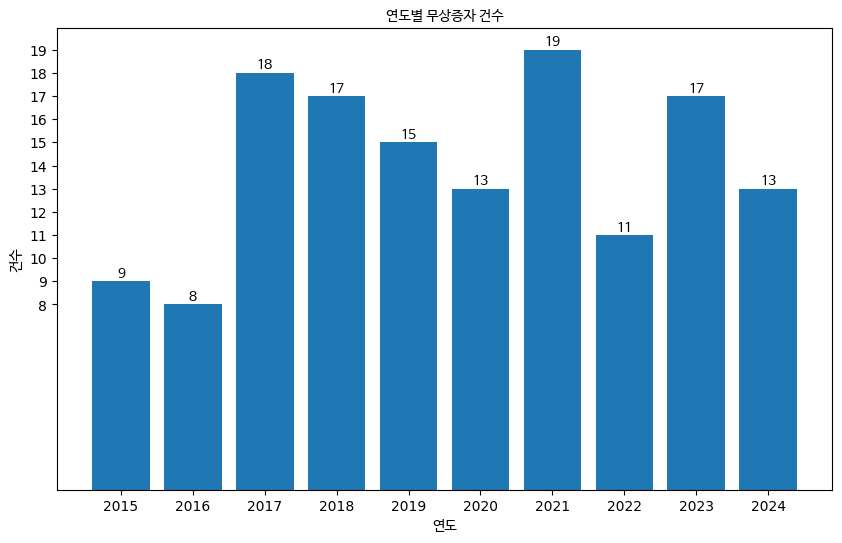

In [17]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# 정수 y축과 x축 눈금 라벨 위에 막대가 정렬된 히스토그램을 만들기
counts, bins, patches = plt.hist(df_dart_bi['연도'], bins=range(int(df_dart_bi['연도'].min()), int(df_dart_bi['연도'].max()) + 2), align='left', rwidth=0.8)

plt.title('연도별 무상증자 건수', fontproperties=font)
plt.xlabel('연도', fontproperties=font)
plt.ylabel('건수', fontproperties=font)
plt.xticks(range(int(df_dart_bi['연도'].min()), int(df_dart_bi['연도'].max()) + 1))

# Y축 틱값을 정수로 전환
plt.yticks(range(int(min(counts)), int(max(counts)) + 1))

# 데이터 레이블 추가
for count, patch in zip(counts, patches):
  plt.text(patch.get_x() + patch.get_width() / 2, count, int(count), ha='center', va='bottom', fontproperties=font)

plt.show()

#### 연도별로 무상증자 비율분포를 대략적으로 확인
이번엔 연도별로 무상증자의 발행비율이 어느수준으로 되었는지 확인해보기로 합니다. 이러한 분석을 위해서는 boxplot을 사용합니다.

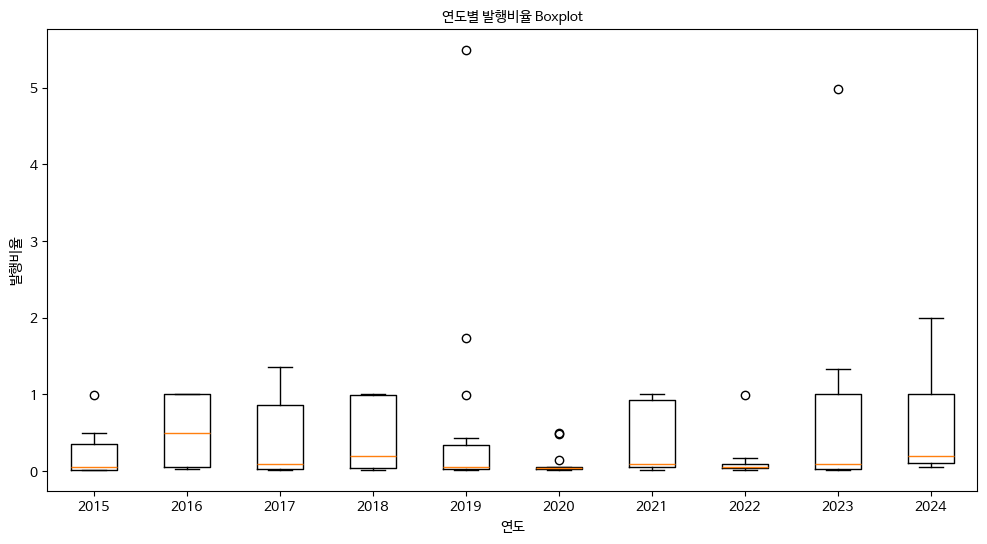

In [29]:
# 고유한 연도 값을 추출하고 정렬
years = sorted(df_dart_bi['연도'].unique())

# 시각화
plt.figure(figsize=(12, 6))
plt.boxplot([df_dart_bi[df_dart_bi['연도'] == year]['발행비율'] for year in years],
            tick_labels=years)
plt.title('연도별 발행비율 Boxplot', fontproperties=font)
plt.xlabel('연도', fontproperties=font)
plt.ylabel('발행비율', fontproperties=font)
plt.xticks(fontproperties=font)
plt.yticks(fontproperties=font)
plt.show()

2019년과 2023년에 발행비율이 5를 넘는 값이 보입니다. 주식이 기존에 1주 있었다면 무상으로 5주나 발행해주었다는 엄청난 비율입니다.<br>
어떤 값인지 확인해 보도록 하겠습니다.

In [22]:
# 발행비율이 4를 넘는 것을 필터
df_outlier = df_dart_bi[df_dart_bi['발행비율'] > 4]

# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_outlier.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)
df_outlier


<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>신주의수</th>
      <th>기존발행주식수</th>
      <th>1주당신주</th>
      <th>배정기준일</th>
      <th>상장예정일</th>
      <th>이사회결의일</th>
      <th>연도</th>
      <th>발행비율</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>미래산업</td>
      <td>2023-08-03</td>
      <td>25340475</td>
      <td>5089295</td>
      <td>5.000000</td>
      <td>2023-08-18</td>
      <td>2023-09-04</td>
      <td>2023-08-03</td>
      <td>2023</td>
      <td>4.979172</td>
    </tr>
    <tr>
      <td>미원상사</td>
      <td>2019-02-28</td>
      <td>4259883</td>
      <td>774940</td>
      <td>5.497049</td>
      <td>2019-04-01</td>
      <td>2019-04-18</td>
      <td>2019-02-27</td>
      <td>2019</td>
      <td>5.497049</td>
    </tr>
  </tbody>
</table>


,회사명,접수일,신주의수,기존발행주식수,1주당신주,배정기준일,상장예정일,이사회결의일,연도,발행비율
62,미래산업,2023-08-03,25340475,5089295,5.000000,2023-08-18,2023-09-04,2023-08-03,2023,4.979172
63,미원상사,2019-02-28,4259883,774940,5.497049,2019-04-01,2019-04-18,2019-02-27,2019,5.497049


[2019.2.27 미원상사](https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20190228000002), [2023.8.3 미래산업](https://dart.fss.or.kr/dsaf001/main.do?rcpNo=20230803000235) 입니다. 공시를 확인하니 오타없이 진짜 5를 넘는 발행비율을 기록하였습니다.<br>
한편, 이 두 케이스 때문에 그래프가 아래쪽으로 쏠려있습니다. 그래서 이번엔 발행비율이 2를 넘어가는 데이터 행을 제거하고(아웃라이어를 제거하고) 다시 그려보았습니다.

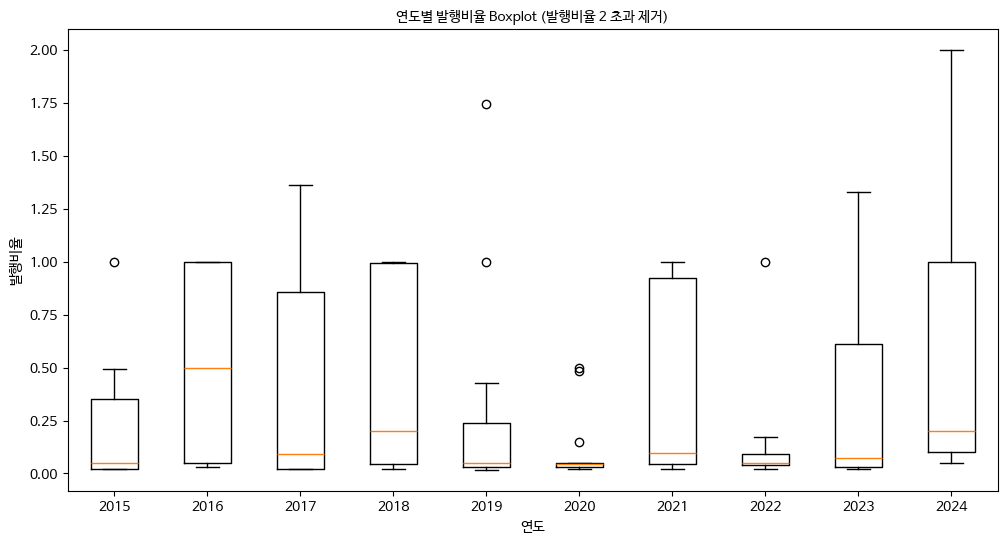

In [28]:
# '발행비율'이 2보다 작은 경우 데이터 제거
df_filtered = df_dart_bi[df_dart_bi['발행비율'] <= 2]

# 시각화
plt.figure(figsize=(12, 6))
plt.boxplot([df_filtered[df_filtered['연도'] == year]['발행비율'] for year in years],
            tick_labels=years)
plt.title('연도별 발행비율 Boxplot (발행비율 2 초과 제거)', fontproperties=font)
plt.xlabel('연도', fontproperties=font)
plt.ylabel('발행비율', fontproperties=font)
plt.xticks(fontproperties=font)
plt.yticks(fontproperties=font)
plt.show()

아웃라이어를 제거한 박스플롯에서 보이는 몇가지 점을 짚어보자면 아래와 같습니다.
* boxplot을 보면 코스피 시장에서 무상증자 비율은 '통상' 1배이하(box의 상단이 1)로 보입니다. <br>
* 2016년을 제외하고는 중위수(주황색 선)이 0.25 밑에 있는 것을 봐서 무상증자의 과반수는 25%를 넘지 않는 수준으로 볼 수도 있습니다.<br>
* 2020년과 2022년에는 무상증자 건수가 각각 13, 11건씩 있었는데도 발행비율은 많이 몰려있었습니다.
* 발행비율의 결정은 회사의 상황마다 천차만별일 것이므로, 이런 기술통계값으로 아직 의미를 도출하기에는 충분하지는 않아 보입니다.
<br><br>
다음 포스팅에서는 각 무상증자 결정이 주가에 미친 영향에 대해 확인해보도록 하겠습니다.